# Recurrent Neural Network - Univariate
- Simple RNN
- LSTM
- GRU
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

## In order to use LSTM and GRU, you need to downgrade numpy
- `conda create --name tf tensorflow=2.4`
- `conda activate tf`
- `conda install numpy=1.19`
- `conda install jupyterlab matplotlib pandas`
- https://stackoverflow.com/questions/66207609/notimplementederror-cannot-convert-a-symbolic-tensor-lstm-2-strided-slice0-t

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [6]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [7]:
# choose a number of time steps
n_steps = 4

In [8]:
# split into samples
X_, y = split_sequence(raw_seq, n_steps)

# visualize input
temp = pd.DataFrame(data=X_, columns=['X1-Time1','X1-Time2','X1-Time3','X1-Time4'])
temp['y'] = y
temp.index.name='sample'
display(temp)

,X1-Time1,X1-Time2,X1-Time3,X1-Time4,y
sample,,,,,
0,10,20,30,40,50
1,20,30,40,50,60
2,30,40,50,60,70
3,40,50,60,70,80
4,50,60,70,80,90


In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X_.reshape((X_.shape[0], n_seq, 1, n_steps, n_features))

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D

def createModel(type):
    inputLayer = Input(shape=(n_seq, 1, n_steps, n_features))

    if (type == 'ConvLSTM'):
        layer = ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu')(inputLayer)
        layer = Flatten()(layer)
    
    outputLayer = Dense(1)(layer)
    model = Model(inputs=inputLayer, outputs=outputLayer, name=type)

    return model


In [11]:
# Model building
tf.keras.backend.clear_session()
tf.random.set_seed(1)
# For somereason if I don't include this, I cannot execute this cell twice for LSTM and GRU
from tensorflow.keras.layers import LSTM, GRU

ConvLSTM = createModel('ConvLSTM')

ConvLSTM.summary()

2023-12-03 05:47:20.722763: I external/local_xla/xla/service/service.cc:168] XLA service 0x555578f4b280 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-03 05:47:20.722817: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-03 05:47:20.723400: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2023-12-03 05:47:20.723656: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 05:47:20.723700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 05:47:20.723724: I external/local_xla/xla/stream_executor/c

Model: "ConvLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1, 2, 1)]      0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          33536     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 33601 (131.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-03 05:47:21.520535: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

def runModel(model, X, y, **kwargs):

    learning_rate = 0.001
    if 'learning_rate' in kwargs:
        learning_rate = kwargs['learning_rate']

    patience = 10
    if 'patience' in kwargs:
        patience = kwargs['patience']

    epochs=200
    if 'epochs' in kwargs:
        epochs = kwargs['epochs']

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    earlyStoppingCallback = EarlyStopping(monitor='loss', patience=patience, min_delta=0)

    history = model.fit(X, y, epochs=epochs, verbose=1, callbacks=[earlyStoppingCallback ])

    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    plt.show()

Epoch 1/2000


2023-12-03 05:47:23.032238: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-03 05:47:23.290361: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-03 05:47:24.356667: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701557244.440885    1836 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 4s 4s/step - loss: 4938.7881
Epoch 2/2000
1/1 [==============================] - 0s 30ms/step - loss: 4818.4326
Epoch 3/2000
1/1 [==============================] - 0s 17ms/step - loss: 4701.7788
Epoch 4/2000
1/1 [==============================] - 0s 18ms/step - loss: 4589.4443
Epoch 5/2000
1/1 [==============================] - 0s 21ms/step - loss: 4479.4111
Epoch 6/2000
1/1 [==============================] - 0s 26ms/step - loss: 4366.0933
Epoch 7/2000
1/1 [==============================] - 0s 21ms/step - loss: 4254.0410
Epoch 8/2000
1/1 [==============================] - 0s 20ms/step - loss: 4146.6494
Epoch 9/2000
1/1 [==============================] - 0s 19ms/step - loss: 4038.7891
Epoch 10/2000
1/1 [==============================] - 0s 27ms/step - loss: 3930.8965
Epoch 11/2000
1/1 [==============================] - 0s 19ms/step - loss: 3821.5493
Epoch 12/2000
1/1 [==============================] - 0s 19ms/step - loss: 3709.7876
Epoch 13/2000
1/

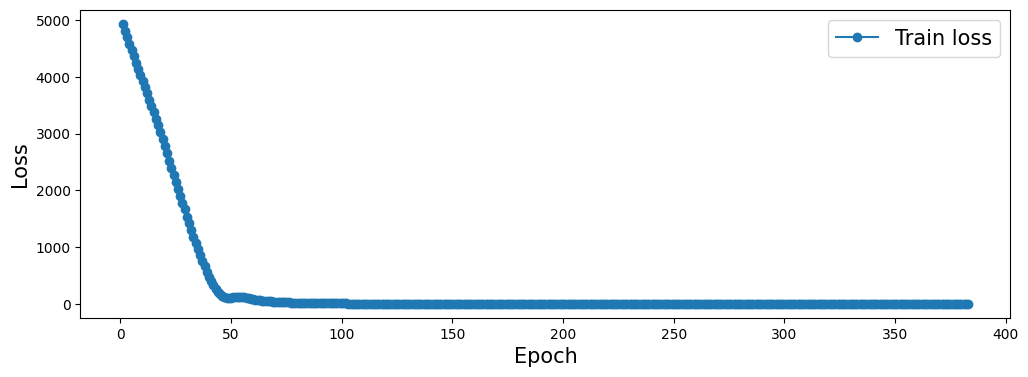

In [13]:
runModel(ConvLSTM, X, y, learning_rate=0.001, epochs=2000, patience=30)

In [14]:
def predictValue(model, X_):
    X = X_.reshape((1, n_seq, 1, n_steps, n_features))
    yhat_ = model.predict(X, verbose=0)
    yhat = yhat_.flatten()[0]
    return yhat

In [15]:
X_ = np.array([60, 70, 80, 90])
print(f"ConvLSTM: {predictValue(ConvLSTM, X_):5.3f}")

ConvLSTM: 103.394
